In [2]:
import pandas as pd

In [2]:
# load the csv files
test = pd.read_csv("../data/raw_data/dreaddit-test.csv")
train = pd.read_csv("../data/raw_data/dreaddit-train.csv")

# concat all the data
df = pd.concat([train,test], ignore_index=True)
df.shape

(3553, 116)

In [3]:
df.head(3)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1.535936e+09,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894


In [4]:
df.duplicated().sum()

0

In [5]:
# export as csv file
df.to_csv('../data/clean_data/model_training.csv', index=False)

In [5]:
# reload the file
stress = pd.read_csv('../data/clean_data/model_training.csv')

In [7]:
stress.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label',
       'confidence', 'social_timestamp', 'social_karma', 'syntax_ari',
       ...
       'lex_dal_min_pleasantness', 'lex_dal_min_activation',
       'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment'],
      dtype='object', length=116)

In [8]:
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Columns: 116 entries, subreddit to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 3.1+ MB


In [14]:
# rename column "label" 

stress = stress.rename(columns={"label":"stress"})

# Preparation of text

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and get English stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\54189\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\54189\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\54189\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())  # Convert to lower case
    # Remove stopwords and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(lemmatized_tokens)

# Apply preprocessing to the text data
stress['processed_text'] = stress['text'].apply(preprocess_text)

# Show the processed text
stress[['text', 'processed_text']].head()

,text,processed_text
0,"He said he had not felt that way before, sugge...",said felt way suggeted go rest trigger ahead y...
1,"Hey there r/assistance, Not sure if this is th...",hey sure right place post go currently student...
2,My mom then hit me with the newspaper and it s...,mom hit newspaper shocked would know like play...
3,"until i met my new boyfriend, he is amazing, h...",met new boyfriend amazing kind sweet good stud...
4,October is Domestic Violence Awareness Month a...,october domestic violence awareness month dome...


# Model training - LogisticRegression

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
# Prepare data
X = stress['processed_text']
y = stress['stress']  # Using the 'stress' column as the target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a text classification pipeline with TF-IDF and Logistic Regression
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
pred_lr = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       323
           1       0.77      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



<Axes: >

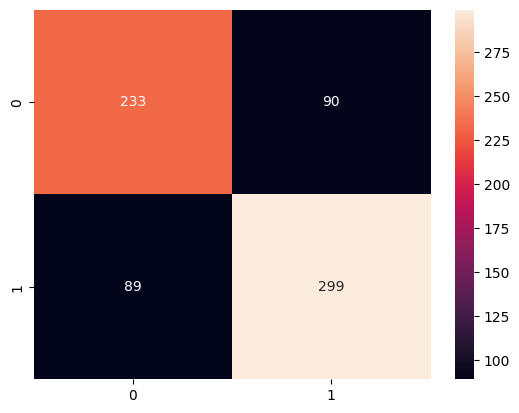

In [17]:
sns.heatmap(confusion_matrix(y_test, pred_lr), annot=True,fmt='g')

# Model training - SVM & RandomForest

In [18]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [19]:
# Create SVM and Random Forest classification pipelines
svm_pipeline = make_pipeline(TfidfVectorizer(), SVC(probability=True))
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

In [20]:
# Train the SVM model
svm_pipeline.fit(X_train, y_train)
# Predict on the test set for SVM
pred_svm = svm_pipeline.predict(X_test)
# Evaluate the SVM model
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       323
           1       0.78      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



<Axes: >

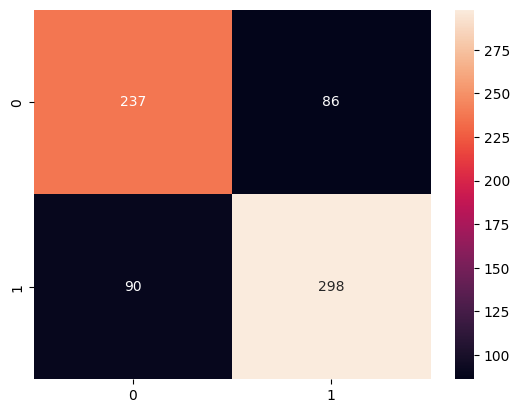

In [21]:
sns.heatmap(confusion_matrix(y_test, pred_svm), annot=True,fmt='g')

In [22]:
# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)
# Predict on the test set for Random Forest
pred_rf = rf_pipeline.predict(X_test)
# Evaluate the Random Forest model
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69       323
           1       0.73      0.85      0.79       388

    accuracy                           0.75       711
   macro avg       0.75      0.73      0.74       711
weighted avg       0.75      0.75      0.74       711



<Axes: >

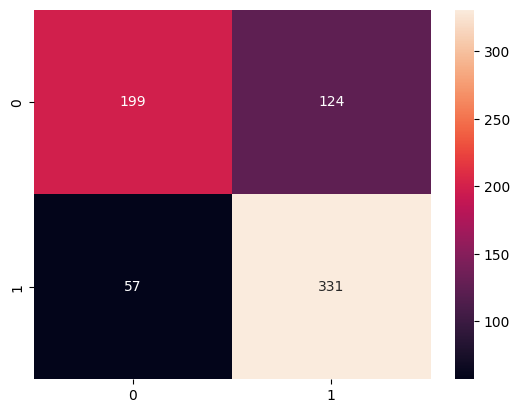

In [23]:
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True,fmt='g')

# Result

Based on the comparison, the results of the LR (Logistic Regression) model and the SVM (Support Vector Machine) model are almost identical. Considering the aspect of interpretability, the LR model was ultimately chosen.

In [24]:
from joblib import dump, load

# save the model as joblib file
dump(pipeline, 'text_stress_lrmodel.joblib')


['text_stress_lrmodel.joblib']

# Apply the model to the clean_reviews.csv

In [25]:
# load csv file
reviews_data = pd.read_csv('../data/clean_data/clean_reviews.csv')
reviews_data.head(3)

,title_id,title,review_no,review
0,111,five feet apart,1,[3.5] There’s some disagreement within the CF ...
1,111,five feet apart,2,Edit: For the love of God I wrote this review ...
2,111,five feet apart,3,Can't say I'm surprised I didn't enjoy this bo...


In [26]:
# preparation of review text
# apply preprocessing to the text
reviews_data['processed_text'] = reviews_data['review'].apply(preprocess_text)
reviews_data[['review', 'processed_text']].head(3)

,review,processed_text
0,[3.5] There’s some disagreement within the CF ...,disagreement within cf community whether book ...
1,Edit: For the love of God I wrote this review ...,edit love god wrote review two year ago still ...
2,Can't say I'm surprised I didn't enjoy this bo...,ca say surprised enjoy book part goodreads rea...


In [27]:
# load the model
model = load('text_stress_lrmodel.joblib')

In [28]:
reviews_data['predicted_stress'] = model.predict(reviews_data['review'])
reviews_data[['review', 'predicted_stress']].head()

,review,predicted_stress
0,[3.5] There’s some disagreement within the CF ...,0
1,Edit: For the love of God I wrote this review ...,0
2,Can't say I'm surprised I didn't enjoy this bo...,0
3,Being subjected to mental and emotional pain c...,0
4,Two things before I start my review:1. I reall...,1


In [29]:
reviews_data['predicted_stress'].value_counts()

predicted_stress
0    15219
1     1641
Name: count, dtype: int64

In [30]:
# save the result
reviews_data.to_csv('../data/clean_data/reviews_with_stress.csv')